In [1]:
from model import Net, resize
import torch


BATCH_SIZE = 64
EPOCH_NUM = 10

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU, "mps" for Apple Mx, or "cpu" to train w/o GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__}"
)

Training on cuda using PyTorch 2.3.0+cu121


# Load data

In [2]:
import numpy as np
import glob
import os
from typing import Union, Callable


# Binary file reading
def read_binary(file_path: str) -> np.ndarray:
    with open(file_path, "rb") as f:
        return np.frombuffer(f.read(), dtype=np.uint8)


# Load all files from a folder, and resize them
def load_folder(dir_path: str, filter: None | Callable[[str], bool]) -> np.ndarray:
    return np.array(
        [
            resize(read_binary(file_path))
            for file_path in glob.glob(os.path.join(dir_path, "*"))
            if filter is None or filter(file_path)
        ]
    )


DTYPE = torch.float32


# Load benign and malware files for given dataset
def load(
    what: Union["test", "train", "victim"],
    benign_filter: None | Callable[[str], bool] = None,
    malware_filter: None | Callable[[str], bool] = None,
    data_dir: str = "data",
) -> tuple[torch.Tensor, torch.Tensor]:
    benign_files = load_folder(os.path.join(data_dir, what, "benign"), benign_filter)
    malware_files = load_folder(os.path.join(data_dir, what, "malware"), malware_filter)

    x = np.concatenate((benign_files, malware_files))
    y = np.concatenate(
        (
            np.zeros(len(benign_files), dtype=np.uint8),
            np.ones(len(malware_files), dtype=np.uint8),
        )
    )

    x_tensor = torch.tensor(x, dtype=DTYPE).unsqueeze(1)
    y_tensor = torch.tensor(y, dtype=DTYPE).unsqueeze(1)

    return x_tensor, y_tensor


X_TRAIN, Y_TRAIN = load("train")

## Preparation: Train models with different initialization and random seed

In [3]:
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(0)

# function to train model with given type x,y -> model
def train_model(x_train: torch.Tensor, y_train: torch.Tensor) -> torch.nn.Module:
    model = Net().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCELoss()

    train_data = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(EPOCH_NUM):
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            optimizer.zero_grad()
            y_pred = model(x_batch)
            y_pred = torch.sigmoid(y_pred)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    return model


baseline_models = [train_model(X_TRAIN, Y_TRAIN) for _ in range(5)]

# Task 1: Label-flipping attack

## 1.1

In [4]:
# choose p% from x,y randomly
def random_poison(
    x: torch.Tensor, y: torch.Tensor, p: float
) -> tuple[torch.Tensor, torch.Tensor]:
    assert x.size(0) == y.size(0), "x and y should have the same size"
    assert 0 <= p <= 1, "p should be between 0 and 1"
    num_samples = int(p * x.size(0))
    indices = torch.randperm(x.size(0))
    selected_indices = indices[:num_samples]
    return x[selected_indices], 1 - y[selected_indices]

# function to train model with random poison added 
def train_random_poisoned_model(
    x_train: torch.Tensor, y_train: torch.Tensor, p: float
) -> torch.nn.Module:
    x_poisoned, y_poisoned = random_poison(x_train, y_train, p)
    x_train = torch.cat((x_train, x_poisoned))
    y_train = torch.cat((y_train, y_poisoned))
    return train_model(x_train, y_train)

# produce the list of tuples of 5 models for each p% of random poison
random_poisoned_models_list = [
    ([train_random_poisoned_model(X_TRAIN, Y_TRAIN, p) for _ in range(5)], p)
    for p in [0.3, 0.5, 0.7]
]

In [5]:
X_TEST, Y_TEST = load("test")

# function to test model on given dataset
def test_model(
    model: torch.nn.Module, x_test: torch.Tensor, y_test: torch.Tensor
) -> float:
    model.eval()
    x_test = x_test.to(DEVICE)
    y_test = y_test.to(DEVICE)
    y_pred = model(x_test)
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > 0.5).float()
    return (y_pred == y_test).float().mean().item()


baseline_results = [test_model(baseline_model, X_TEST, Y_TEST) for baseline_model in baseline_models]
random_poisoned_test_results_list = [
    (
        [
            test_model(random_poisoned_model, X_TEST, Y_TEST)
            for random_poisoned_model in random_poisoned_models
        ],
        p,
    )
    for random_poisoned_models, p in random_poisoned_models_list
]

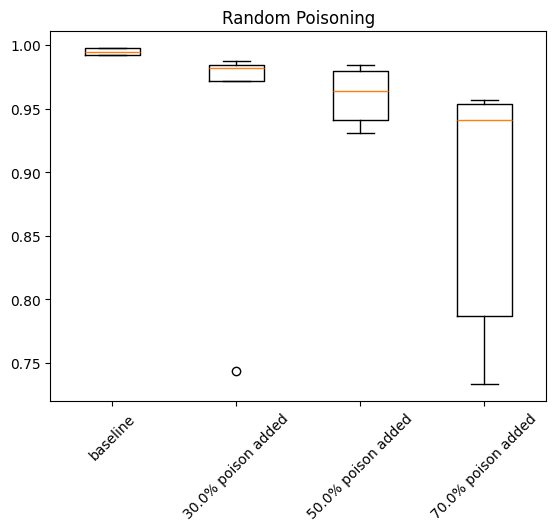

In [6]:
import matplotlib.pyplot as plt

# it is extracted to avoid code duplication
def plot_results(baseline_results: list[float], poisoned_test_results_list:list[tuple[list[float], float]], title: str):
    test_results = [baseline_results] + [
        poisoned_test_results for poisoned_test_results, _ in poisoned_test_results_list
    ]
    test_labels = ["baseline"] + [
        f"{p*100}% poison added" for _, p in poisoned_test_results_list
    ]

    plt.figure()
    plt.boxplot(test_results)
    plt.xticks(range(1, len(test_labels) + 1), test_labels, rotation=45)
    plt.title(title)
    plt.show()


plot_results(baseline_results, random_poisoned_test_results_list, "Random Poisoning")

## 1.2

In [7]:
# function to choose poison samples with max loss (p%)
def max_loss_poison(
    x: torch.Tensor, y: torch.Tensor, p: float, baseline_models: list[torch.nn.Module]
) -> tuple[torch.Tensor, torch.Tensor]:
    assert x.size(0) == y.size(0), "x and y should have the same size"
    assert 0 <= p <= 1, "p should be between 0 and 1"
    num_samples = int(p * x.size(0))
    train_data = TensorDataset(x, y)
    train_loader = DataLoader(train_data, batch_size=1, shuffle=False)
    losses = []
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        loss = 0
        for model in baseline_models:
            model.eval()
            y_pred = model(x_batch)
            y_pred = torch.sigmoid(y_pred)
            loss += torch.functional.F.binary_cross_entropy(y_pred, 1 - y_batch).item()
        # Pointless to calculate average, sorting by sum is equivalent
        losses.append((i, loss))
    losses.sort(key=lambda x: x[1], reverse=True)
    selected_indices = [i for i, _ in losses[:num_samples]]
    return x[selected_indices], 1 - y[selected_indices]

# function to train model with max loss poisoned samples
def train_max_loss_poisoned_model(
    x_train: torch.Tensor,
    y_train: torch.Tensor,
    p: float,
    baseline_models: list[torch.nn.Module],
) -> torch.nn.Module:
    x_poisoned, y_poisoned = max_loss_poison(x_train, y_train, p, baseline_models)
    x_train = torch.cat((x_train, x_poisoned))
    y_train = torch.cat((y_train, y_poisoned))
    return train_model(x_train, y_train)

# produce the list of tuples of 5 models for each p% of random poison
max_loss_poisoned_models_list = [
    (
        [
            train_max_loss_poisoned_model(X_TRAIN, Y_TRAIN, p, baseline_models)
            for _ in range(5)
        ],
        p,
    )
    for p in [0.3, 0.5, 0.7]
]

In [8]:
max_loss_poisoned_test_results_list = [
    (
        [
            test_model(max_loss_poisoned_model, X_TEST, Y_TEST)
            for max_loss_poisoned_model in max_loss_poisoned_models
        ],
        p,
    )
    for max_loss_poisoned_models, p in max_loss_poisoned_models_list
]

In [9]:
plot_results(baseline_results, max_loss_poisoned_test_results_list, "Max Loss Poisoning")

## 1.3

Az egyik esetben random választottuk a poison mintákat, míg másik esetben a legnagyobb loss-t előidéző mintákat (label flip után). Egyértelműen az utóbbi a hatékonyabb megioldás, mert a nagyobb loss jobban elmozdítja a modellt a rossz irányba. Ez látszik a boxplot diagrammokon is.

## 1.4

Ez a támadás könnyen megvalósítható a gyakorlatban, de a hatékonyság eléréséhez nagy arányú poisoning szükséges, ami viszont könnyed detektálható. Védekezés lehetséges Outlier detektálással és szűréssel, például k-NN vagy SEVER alkalmazásával.

# Task 2: Targeted poisoning attack

## Read targets from given file

In [10]:
import json

# read json
def get_selected(what: Union["benign", "malware"]) -> list[str]:
    with open(f"{what}_victims.json") as f:
        return json.load(f)


selected_benign = get_selected("benign")
selected_malware = get_selected("malware")

# load victims
X_VICTIM, Y_VICTIM = load(
    "victim",
    benign_filter=lambda file_path: file_path.split("/")[3] in selected_benign,
    malware_filter=lambda file_path: file_path.split("/")[3] in selected_malware,
)

## Select base samples from the test set with the largest cosine similarity to the target sample

In [11]:
from functorch import grad, grad_and_value, make_functional_with_buffers
from torch.nn.utils import parameters_to_vector

# function to calculate BCE loss
def loss_func(func, params, buffers, x, y):
    y_pred = func(params, buffers, x)
    y_pred = torch.sigmoid(y_pred)
    loss = torch.functional.F.binary_cross_entropy(y_pred, y)
    return loss

# for a given sample, it produses first p item of samples with max cosine similarity
# for each train sample for each modell cosine similarity is calculated, then average is taken, then sorted, then first p is selected
def select_top_p_based_on_cosine_similarity(
    x_target: torch.Tensor,  # Contains only one sample
    y_target: torch.Tensor,
    x: torch.Tensor,  # Contains all test samples
    y: torch.Tensor,
    p: int,
    baseline_models: list[torch.nn.Module],
) -> tuple[torch.Tensor, torch.Tensor]:
    train_data = TensorDataset(x, y)
    train_loader = DataLoader(train_data, batch_size=1, shuffle=False)
    cosine_similarities = []
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        inner_cosine_similarities = []
        for model in baseline_models:
            func, param, buffers = make_functional_with_buffers(model)
            grad_func = grad(loss_func, 1)
            grad_target = parameters_to_vector(
                grad_func(func, param, buffers, x_target, 1-y_target)
            )
            grad_batch = parameters_to_vector(
                grad_func(func, param, buffers, x_batch, y_batch)
            )
            cosine_similarity = torch.nn.functional.cosine_similarity(
                grad_target, grad_batch, dim=0
            )
            inner_cosine_similarities.append(cosine_similarity.detach().cpu())
        cosine_similarity = np.array(inner_cosine_similarities).mean()
        cosine_similarities.append((i, cosine_similarity))
    cosine_similarities.sort(key=lambda x: x[1], reverse=True)
    selected_indices = [i for i, _ in cosine_similarities[:p]]
    return x[selected_indices], y[selected_indices]

## Poisoning attack: Witches' brew
Solve  
$$\min_{\{\delta_1, \ldots, \delta_p\}} \frac{1}{5}\sum_{j=1}^5 \sum_{(x_i,y_i)\in D_t'} (1 - \cos\angle(\nabla_\theta loss_f(\theta_j, x_t, y_t^{adv}), \nabla_\theta loss_f(\theta_j, x_i + \delta_i, y_i)))$$

In [12]:
from tqdm import tqdm


# function to calculate WiB loss
def WiB_Loss(delta, x_target, y_target, x, y, baseline_models):
    input = delta + x
    loss = torch.zeros([]).to(DEVICE)
    for model in baseline_models:
        func, params, buffers = make_functional_with_buffers(model)
        grad1 = parameters_to_vector(
            grad(loss_func, 1)(func, params, buffers, x_target, 1 - y_target)
        )
        for x_i, y_i in zip(input, y):
            grad2 = parameters_to_vector(
                grad(loss_func, 1)(func, params, buffers, x_i[None, :], y_i[None, :])
            )
            loss += 1 - torch.nn.functional.cosine_similarity(grad1, grad2, dim=0)
    return loss / len(baseline_models)

# WiB attack implementation
# from random noise it tries to find the best noise to add to x_target to make it misclassified
# we have to clamp noise in each iteration
# returns the poisoned data with true label
# tqdm used to follow the progress
def WiB_attack(x_target, y_target, baseline_models, p):
    x_b, y_b = select_top_p_based_on_cosine_similarity(
        x_target, y_target, X_TEST, Y_TEST, p, baseline_models
    )
    x_b, y_b = x_b.to(DEVICE), y_b.to(DEVICE)
    noise = (torch.randn(x_b.shape) * 0.01).to(DEVICE).requires_grad_(True)
    noise.data.clamp_(0 - x_b, 1 - x_b)

    optimizer = torch.optim.SGD([noise], lr=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", factor=0.6, patience=60, eps=1e-06, verbose=True
    )

    losses = []
    for i in tqdm(range(100)):
        optimizer.zero_grad()
        g, loss = grad_and_value(WiB_Loss)(
            noise, x_target, y_target, x_b, y_b, baseline_models
        )
        g = torch.sign(g)
        noise.grad = g
        optimizer.step()
        scheduler.step(loss)
        losses.append(loss.detach().cpu().numpy())
        noise.data.clamp_(0 - x_b, 1 - x_b)
    plt.plot(np.array(losses))
    plt.show()
    x_poisoned = x_b + noise
    return x_poisoned.detach().cpu(), y_b.detach().cpu()

/home/melidon/Egyetem/msc/3_felev/a_gepi_tanulas_biztonsaga/hazi/2/.venv/lib/python3.12/site-packages/torch/_functorch/deprecated.py:104: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional_with_buffers is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional_with_buffers', 'torch.func.functional_call')
/home/melidon/Egyetem/msc/3_felev/a_gepi_tanulas_biztonsaga/hazi/2/.venv/lib/python3.12/site-packages/torch/_functorch/deprecated.py:65: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.grad instead; s

100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


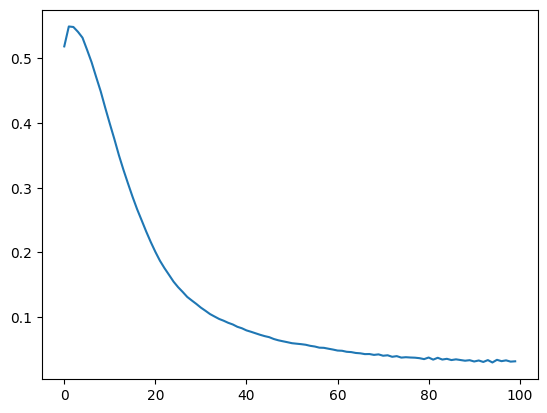

100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


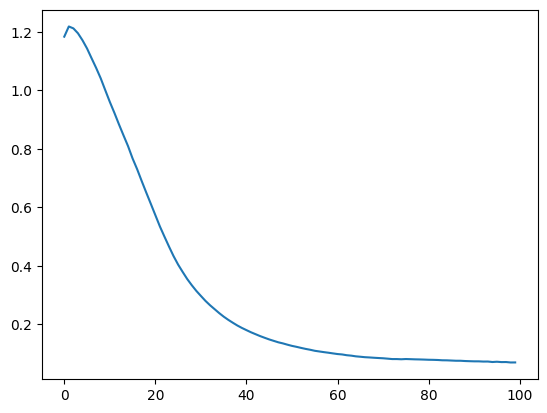

100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


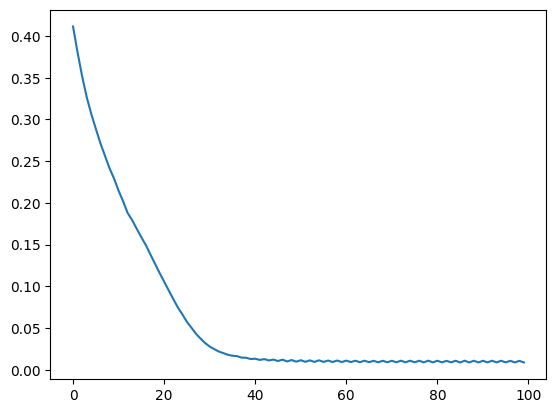

100%|██████████| 100/100 [00:31<00:00,  3.15it/s]


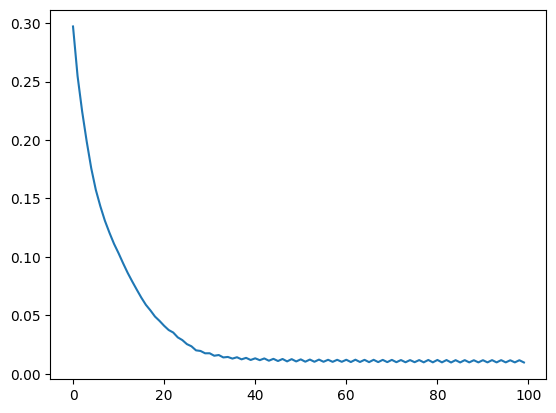

100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


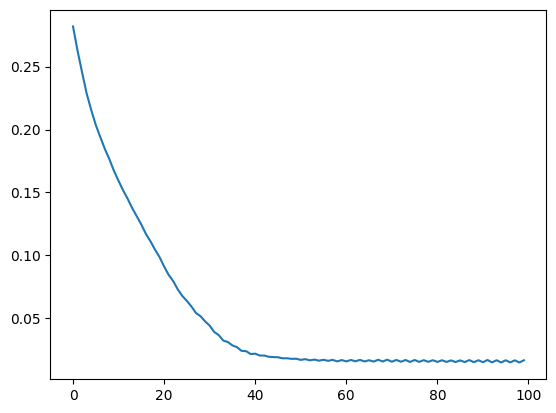

100%|██████████| 100/100 [00:32<00:00,  3.12it/s]


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


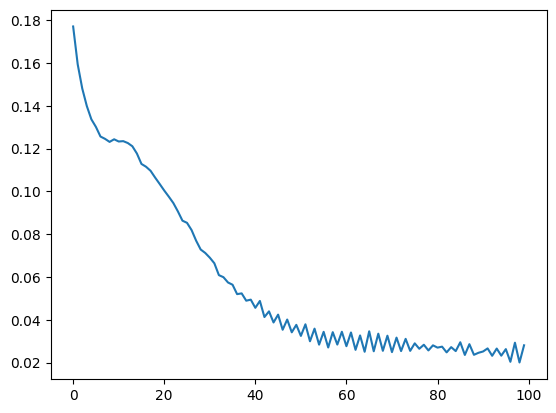

100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


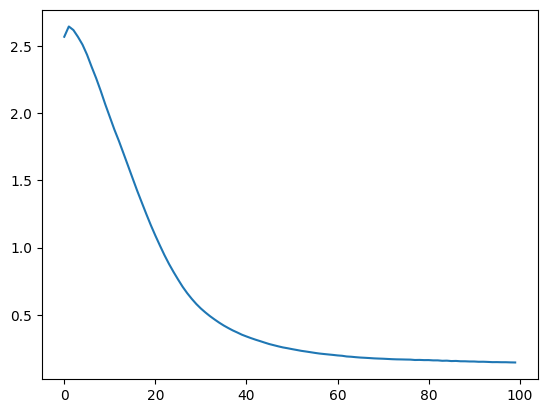

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 

In [13]:
# for each p and each sample we calculate poisoned sample with WiB, and train model with poisoned dataset.
# result: List of tuples included trained poisoned models and p value.
data = TensorDataset(X_VICTIM, Y_VICTIM)
loader = DataLoader(data, batch_size=1, shuffle=False)
wib_poisoned_models_list = []
for p in [5, 10, 15]:
    models = []
    for x_target, y_target in loader:
        x_target = x_target.to(DEVICE)
        y_target = y_target.to(DEVICE)
        x_poisoned, y_poisoned = WiB_attack(x_target, y_target, baseline_models, p)
        x_train = torch.cat((X_TRAIN, x_poisoned))
        y_train = torch.cat((Y_TRAIN, y_poisoned))
        model = train_model(x_train, y_train)
        models.append(model)
    wib_poisoned_models_list.append((models, p))

## Evaluate Targeted Poisoning on All Targets

In [ ]:
wib_poisoned_test_results_list = [
    (
        [
            test_model(wib_poisoned_model, X_TEST, Y_TEST)
            for wib_poisoned_model in wib_poisoned_models
        ],
        p,
    )
    for wib_poisoned_models, p in wib_poisoned_models_list
]

## Plot results

In [ ]:
plot_results(baseline_results, wib_poisoned_test_results_list, "Wib Poisoning")

## 2.2

Ez a támadás nehezebben megvalósítható, mert nagyon erőforrásigényes. Hatékonyságára nem lenne panasz, ha befért volna a cuda memóriába az egész tanítás.
Az így kiszámolt mintákat hozzádjuk az adathalmazhoz és azzal újratanítva a modellt kiértékeljük a támadás sikerességét. Ehhez megvannak a kódjaink, de sajnos nem tudtuk végigfuttatni a Wib-attack-ot magát.

Védekezésre ajánlani k-NN és SEVER Outlier szűrést tudunk.